![](http://mf-data-science.fr/images/projects/banniere.jpg)

# Segmentation de clients (Olist) - Partie 2 : segmentations des clients
---

Dans cette seconde partie nous allons transformer les données par commande en données par client afin de trouver une segmentation pertinente de ces clients.

## Introduction
### Import des librairies

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from scipy.spatial.distance import cdist
from math import *
import warnings

### Import des données

In [2]:
STORAGE_PATH = '../data'
FILENAME = 'order_data.csv'
warnings.filterwarnings("ignore")
sns.set_theme()
seed = 0

In [3]:
order_data = pd.read_csv(os.path.join(STORAGE_PATH, FILENAME))

In [4]:
def get_customer_data(order_data:pd.DataFrame, months_to_remove:int):
    
    order_data.order_purchase_timestamp = pd.to_datetime(order_data.order_purchase_timestamp)
    last_order_time = order_data.order_purchase_timestamp.max()
    last_order_time = last_order_time - pd.DateOffset(months=months_to_remove)
    
    new_order_data = order_data.loc[order_data.order_purchase_timestamp <= last_order_time]
    
    print("Number of orders removed:", len(order_data) - len(new_order_data))
        
    new_order_data['last_order_3m'] = (new_order_data.order_purchase_timestamp > (new_order_data.order_purchase_timestamp.max() - pd.DateOffset(months=3))).astype(int)
    new_order_data['last_order_6m'] = (new_order_data.order_purchase_timestamp > (new_order_data.order_purchase_timestamp.max() - pd.DateOffset(months=6))).astype(int)
    
    customer_data = pd.DataFrame(index = new_order_data.customer_id.unique())
    
    # order
    customer_data['number_order'] = new_order_data.groupby('customer_id').order_id.nunique()
    customer_data['average_order_value'] = new_order_data.groupby('customer_id').order_price.mean()
    customer_data['order_weight'] = new_order_data.groupby('customer_id').order_weight.mean()
    customer_data["order_volume"] = new_order_data.groupby('customer_id').order_volume.mean()
        
    # order time
    customer_data['number_order_last_3m'] = new_order_data.groupby('customer_id').last_order_3m.sum()
    customer_data['number_order_last_6m'] = new_order_data.groupby('customer_id').last_order_6m.sum()
    customer_data['last_order_days'] = (new_order_data.order_purchase_timestamp.max() - new_order_data.sort_values('order_purchase_timestamp').drop_duplicates('customer_id', keep='last').set_index('customer_id').order_purchase_timestamp).dt.days
    customer_data["order_purchase_night"] = new_order_data.groupby('customer_id').order_purchase_night.mean()                   
    customer_data["order_purchase_winter"] = new_order_data.groupby('customer_id').order_purchase_winter.mean()
    
    # delivery
    customer_data['freight_value'] = new_order_data.groupby('customer_id').order_freight_value.mean()
    customer_data["delivered_duration"] = new_order_data.groupby('customer_id').delivery_duration.mean()
    
    # payment
    customer_data['payment_sequential'] = new_order_data.groupby('customer_id').number_sequential_payments.mean()
    customer_data['number_payment_types'] = new_order_data.groupby('customer_id').number_payment_types.mean()
    customer_data['payment_installments'] = new_order_data.groupby('customer_id').number_payment_installments.mean()
    customer_data["payment_type_boleto"] = new_order_data.groupby('customer_id').payment_type_boleto.mean()
    customer_data["payment_type_credit_card"] = new_order_data.groupby('customer_id').payment_type_credit_card.mean()
    customer_data["payment_type_debit_card"] = new_order_data.groupby('customer_id').payment_type_debit_card.mean()
    customer_data["payment_type_voucher"] = new_order_data.groupby('customer_id').payment_type_voucher.mean()
    
    # review
    customer_data['number_review_message'] = new_order_data.groupby('customer_id').number_review_comment_message.mean()
    customer_data['review_score'] = new_order_data.groupby('customer_id').review_score.mean()
    
    # product
    customer_data['product_photos_qty'] = new_order_data.groupby('customer_id').product_photos_qty.mean()
    customer_data["product_categories"] = new_order_data.groupby("customer_id").number_product_categories.mean()
    customer_data['number_product'] = new_order_data.groupby('customer_id').number_product.mean()
    customer_data['number_unique_product'] = new_order_data.groupby('customer_id').number_unique_product.mean()
    
    # customer location
    city_pop = dict(new_order_data.groupby('customer_city').customer_id.nunique())
    new_order_data['city_pop'] = new_order_data.customer_city.apply(lambda x : city_pop[x])
    customer_data['city_pop'] = new_order_data.groupby('customer_id').city_pop.mean()
    
    return customer_data

In [5]:
customer_data = get_customer_data(order_data, months_to_remove=6)
len(customer_data)

Number of orders removed: 39324


55363

### Utils

In [6]:
def train_kmeans(data, n_clusters, random_state=42):
   
    model =  KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = model.fit_predict(data)
    
    return model, cluster_labels

def train_dbscan(data, eps=0.5, min_samples=5, random_state=42):
   
    model =  DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = model.fit_predict(data)
    
    return model, cluster_labels

def draw_pca_plot(data, n_components=2):
    
    data_sc = StandardScaler().fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(data_sc)
    colors = "bgrcmyk"
    
    plt.figure(figsize=(10, 10))
    for i in range(n_clusters):
        plt.scatter(pca_data[cluster_labels == i][:, 0], pca_data[cluster_labels == i][:, 1], label=f"label {i}", color = colors[i], alpha=0.4)
    
    plt.title('PCA', size=20, weight ='bold')
    plt.legend()
    plt.show()

def draw_radar_plot(data, n_clusters, cluster_label, features):
    
    data_sc = QuantileTransformer().fit_transform(data)
    data_sc = pd.DataFrame(data_sc, columns=data.columns) * 10
    data_sc['cluster'] = cluster_labels
    
    colors = "bgrcmyk"
    
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111, polar=True)
    angles = [n / float(len(features)) * 2 * pi for n in range(len(features))]
    angles += angles[:1]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, size=14, weight='bold')
    ax.set_rlabel_position(0)
    ax.set_yticks([0,2, 4, 6, 8, 1])
    ax.tick_params(pad=50)

    for i in range(n_clusters):
        values = data_sc[data_sc.cluster == i][features].mean().tolist()
        values += values[:1]
        color = colors[i]
        ax.plot(angles, values, linewidth=1, linestyle='solid', color=color, label=f"label {i}")
        ax.fill(angles, values, color, alpha=0.1)
    
    plt.title('Radar plot', size=20, weight ='bold')
    plt.legend()
    plt.show()
    
def plot_scores(data, max_clusters, random_state=42):
    
    n_clusters = np.arange(2, max_clusters + 1)
    sse, dbs, ssa = list(), list(), list()
    for n in tqdm(n_clusters):
        kmeans, cluster_labels = train_kmeans(data, n, random_state)
        sse.append(kmeans.inertia_)
        dbs.append(davies_bouldin_score(data, cluster_labels))   
        ssa.append(silhouette_score(data, cluster_labels))

    plt.figure(figsize=(16, 5))
    plt.subplot(131)
    plt.plot(n_clusters, sse, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.title('Elbow method')

    plt.subplot(132)
    plt.plot(n_clusters, dbs, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.title('Davies-Bouldin score')

    plt.subplot(133)
    plt.plot(n_clusters, ssa, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.title('Silhouette score')
    plt.show()

    return sse, dbs, ssa

def draw_cluster_distribution(cluster_labels):
    
    colors = sns.color_palette('coolwarm')
    _ = pd.Series(cluster_labels).value_counts(normalize=True)
    plt.pie(x = _.values, labels= _.index, autopct='%1.f %%', 
            startangle=0,  pctdistance=0.7, colors = colors[3:], 
            textprops={'fontsize': 12, 'weight': 'bold'})
    plt.show()
    
def draw_silhouette_plot(data, n_clusters, cluster_labels, silhouette_avg):
    
    colors = "bgrcmyk"
    plt.figure(figsize=(10, 10))

    y_lower = 0
    for i in range(n_clusters):
        cluster_silhouette_values = np.sort(sample_silhouette_values[cluster_labels == i])
        size_cluster_i = len(cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, color=colors[i], alpha=0.4)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x = silhouette_avg, color="red", linestyle="--", alpha=0.5)
    plt.title("Silhouette plot")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.yticks([])

## Tests de segmentation

### RFM variables

In [7]:
features = ['last_order_days', 'number_order', 'average_order_value']
data = customer_data[features]
max_clusters = 6

100%|█████████████████████████████████████████████| 5/5 [05:11<00:00, 62.33s/it]


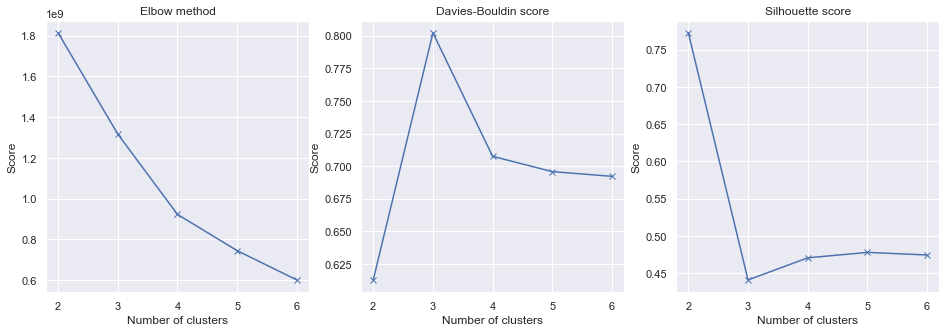

In [8]:
sse, dbs, ssa = plot_scores(data, max_clusters)

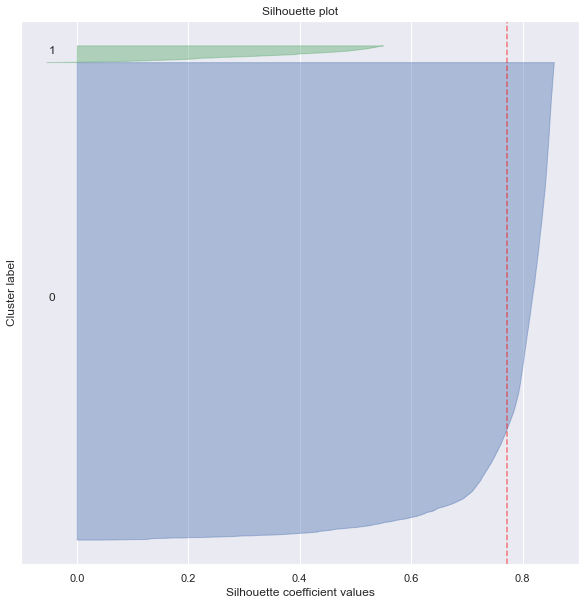

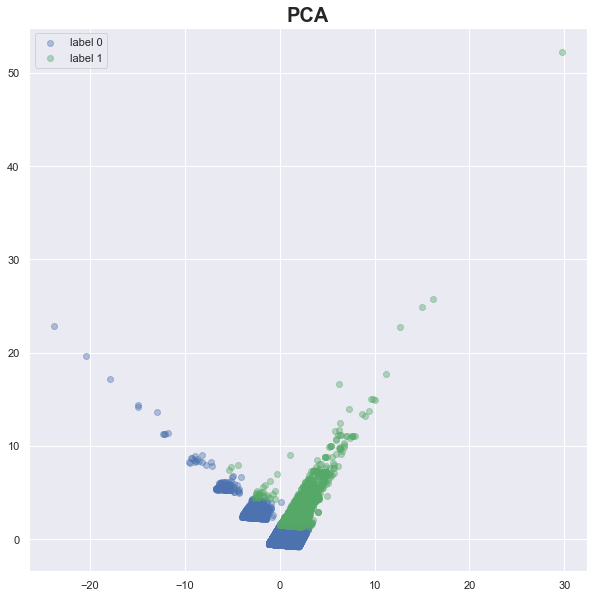

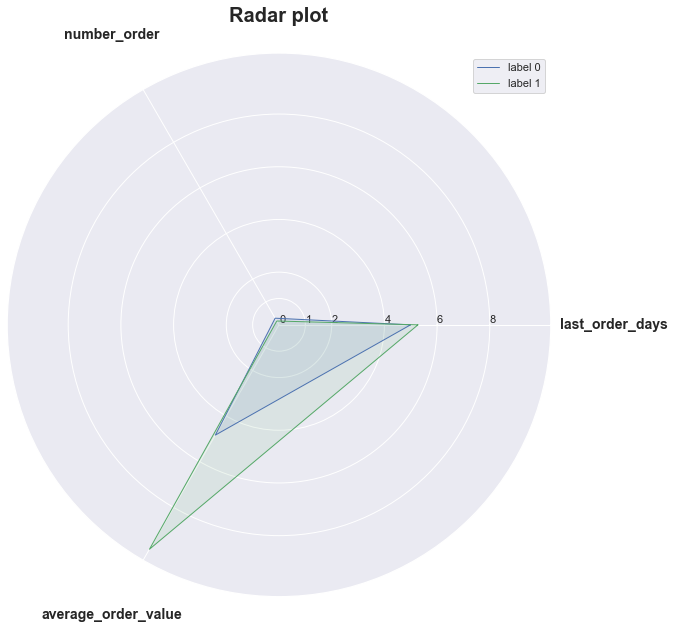

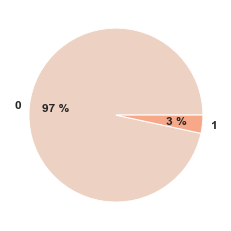

In [9]:
n_clusters = 2
kmeans, cluster_labels = train_kmeans(data, n_clusters)
silhouette_avg = ssa[n_clusters - 2]
sample_silhouette_values = silhouette_samples(data, cluster_labels)
draw_silhouette_plot(data, n_clusters, cluster_labels, silhouette_avg)
draw_pca_plot(data)
draw_radar_plot(data, n_clusters, cluster_labels, features)
draw_cluster_distribution(cluster_labels)

### Most variables features

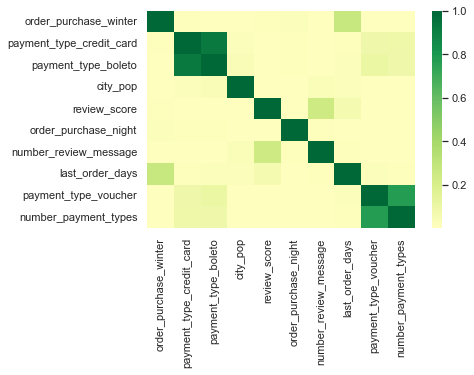

In [10]:
sc = MinMaxScaler()
customer_data_sc = sc.fit_transform(customer_data)
customer_data_sc = pd.DataFrame(customer_data_sc, columns = customer_data.columns)
most_var_features = customer_data_sc.std().sort_values(ascending=False)[:10].index
sns.heatmap(np.abs(customer_data[most_var_features].corr()), cmap = 'RdYlGn', center=0)
plt.show()

100%|█████████████████████████████████████████████| 5/5 [05:40<00:00, 68.07s/it]


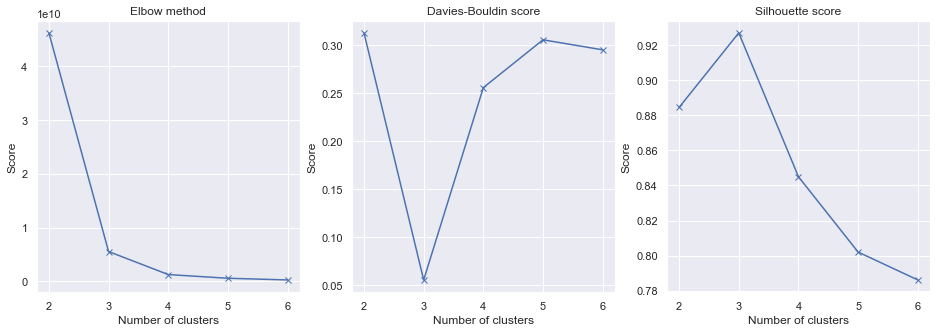

In [11]:
most_var_features = ['order_purchase_winter', 'number_payment_types', 'city_pop', 'review_score', 'order_purchase_night']
data = customer_data[most_var_features]
max_clusters = 6
sse, dbs, ssa = plot_scores(data, max_clusters)

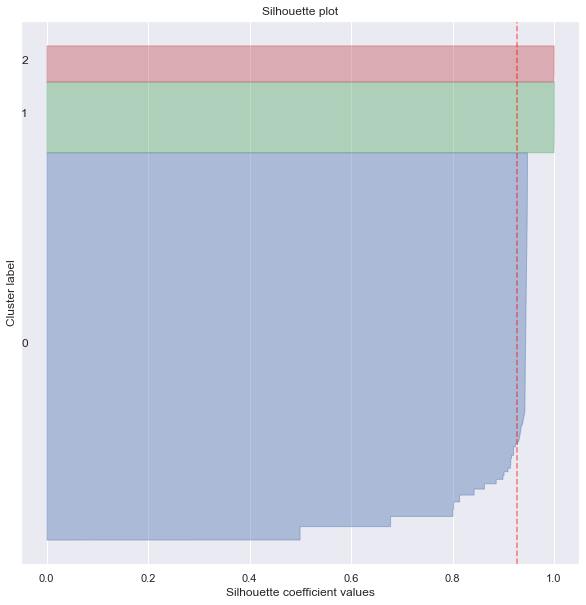

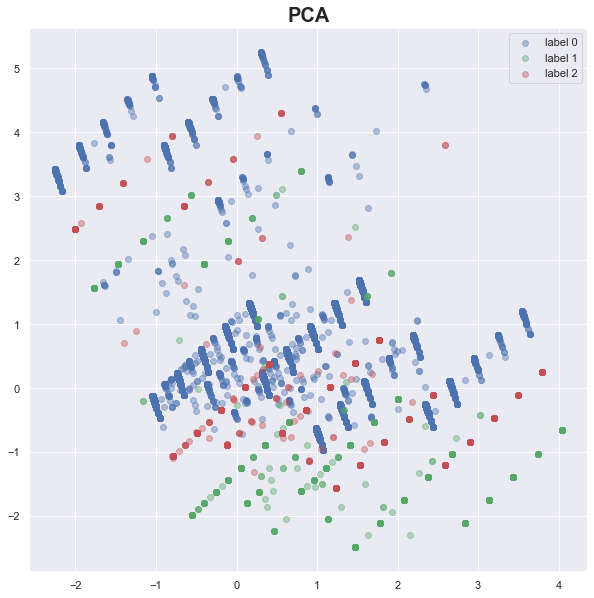

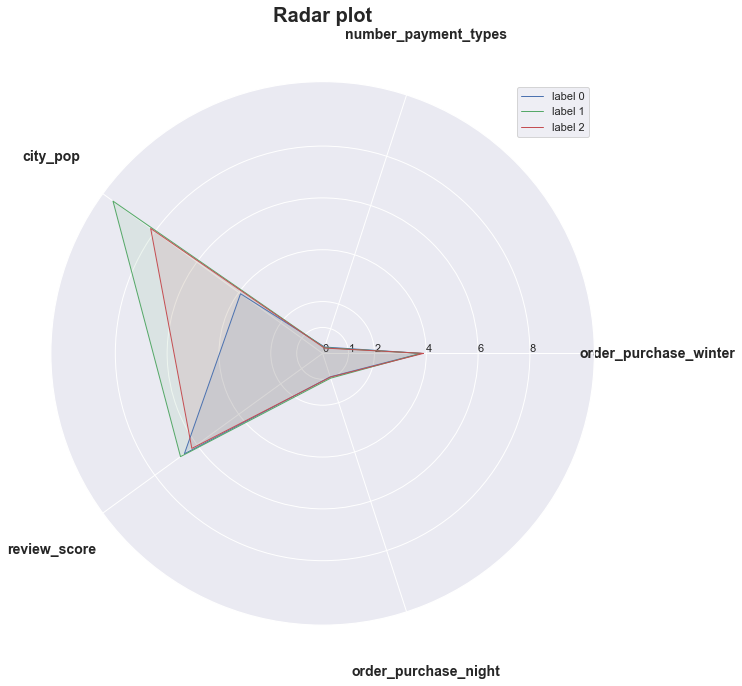

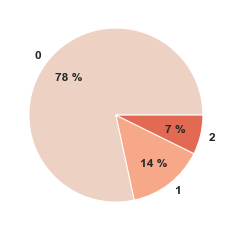

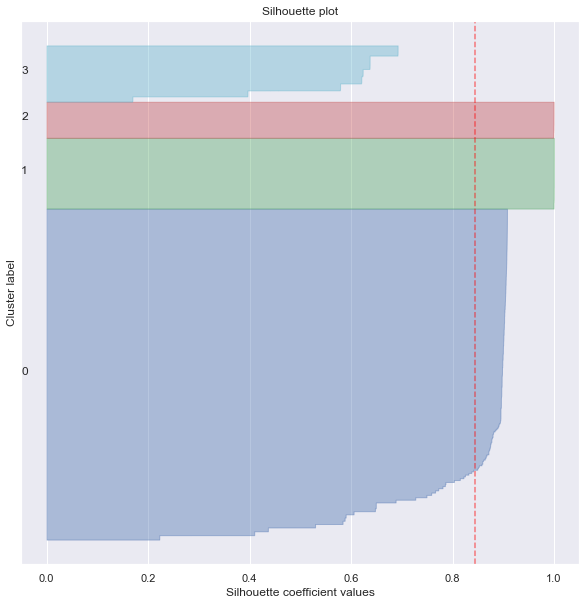

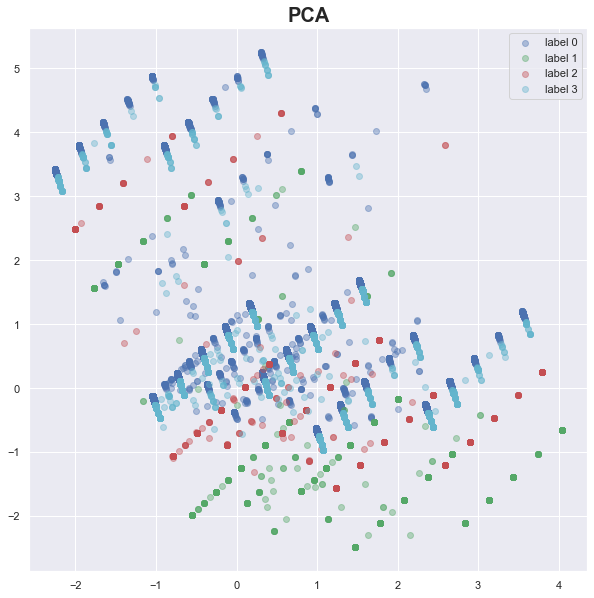

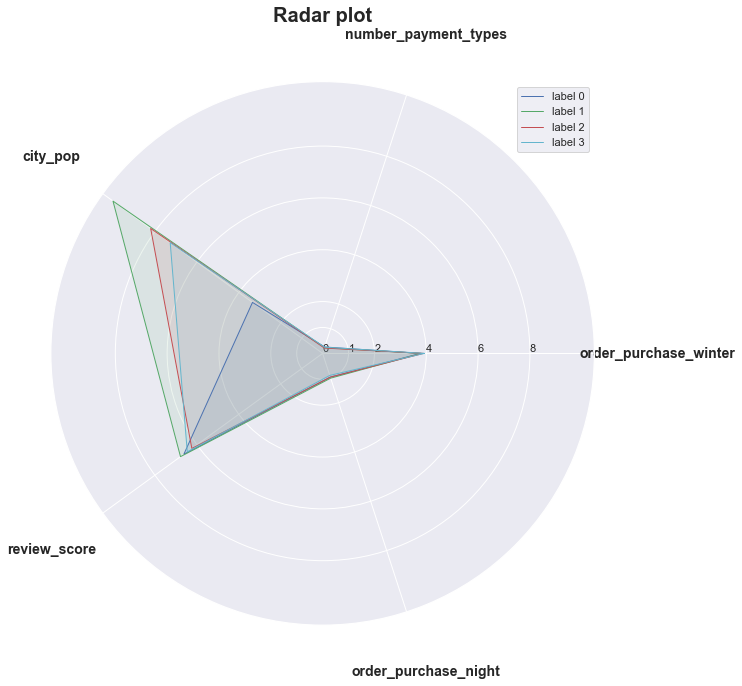

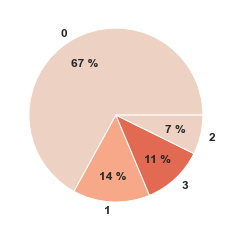

In [12]:
for n_clusters in np.arange(3, 5):
    kmeans, cluster_labels = train_kmeans(data, n_clusters)
    silhouette_avg = ssa[n_clusters - 2]
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    draw_silhouette_plot(data, n_clusters, cluster_labels, silhouette_avg)
    draw_pca_plot(data)
    draw_radar_plot(data, n_clusters, cluster_labels, most_var_features)
    draw_cluster_distribution(cluster_labels)

### Custom variables 1

100%|█████████████████████████████████████████████| 5/5 [05:08<00:00, 61.76s/it]


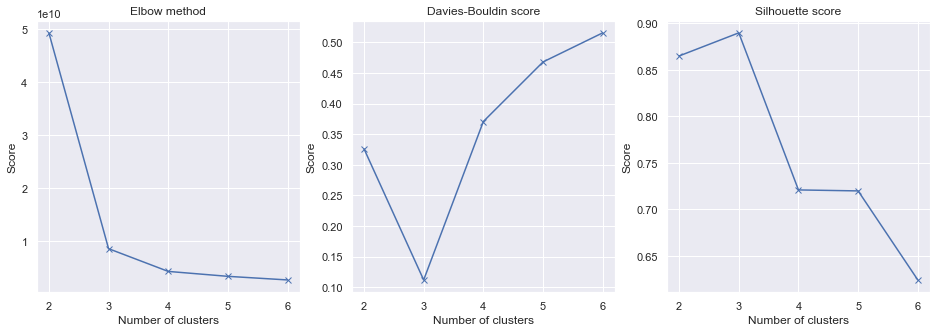

In [13]:
features = [
    "review_score", 
    "average_order_value",
    "city_pop",
    "last_order_days",
    "payment_type_voucher"]

data = customer_data[features]
max_clusters = 6
sse, dbs, ssa = plot_scores(data, max_clusters)

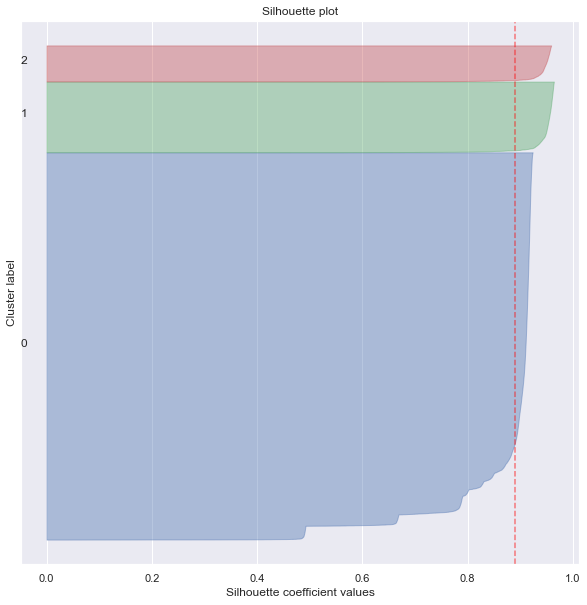

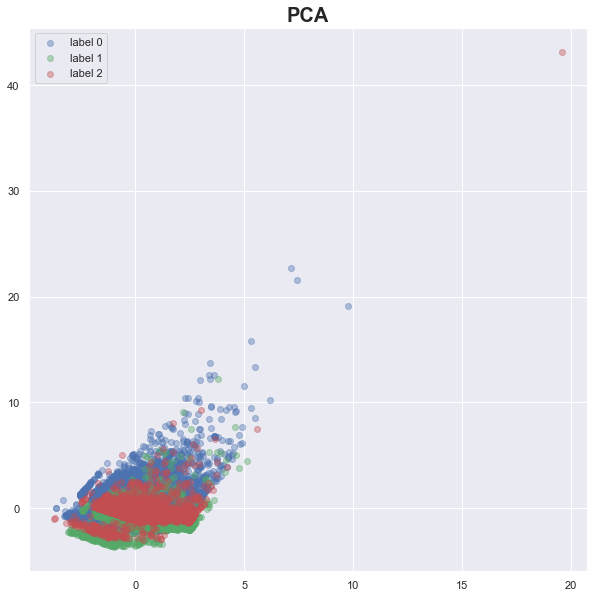

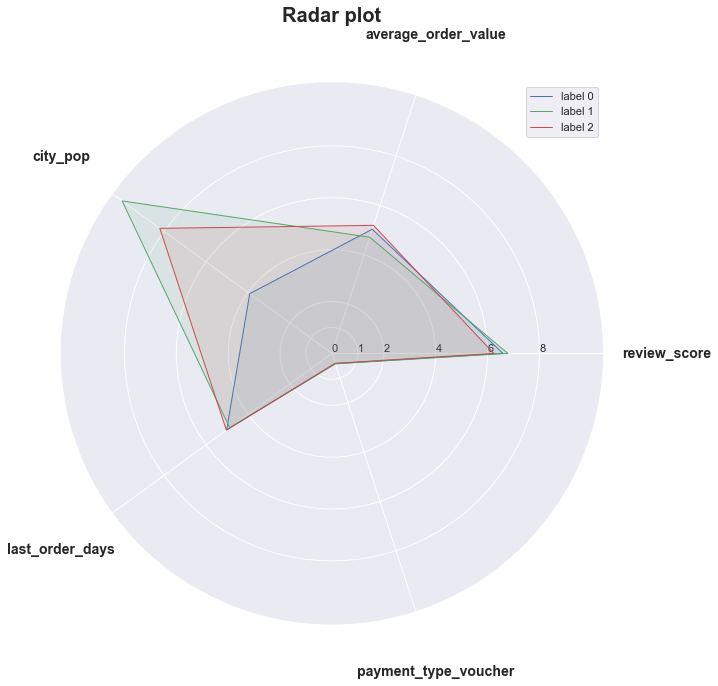

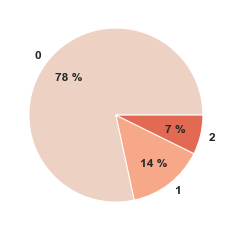

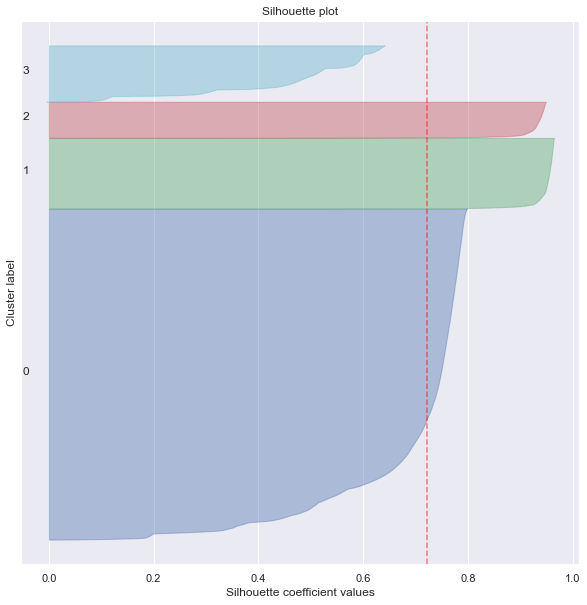

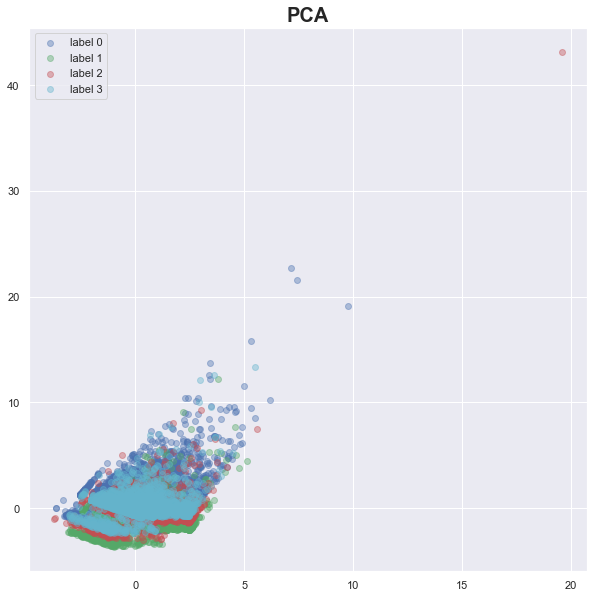

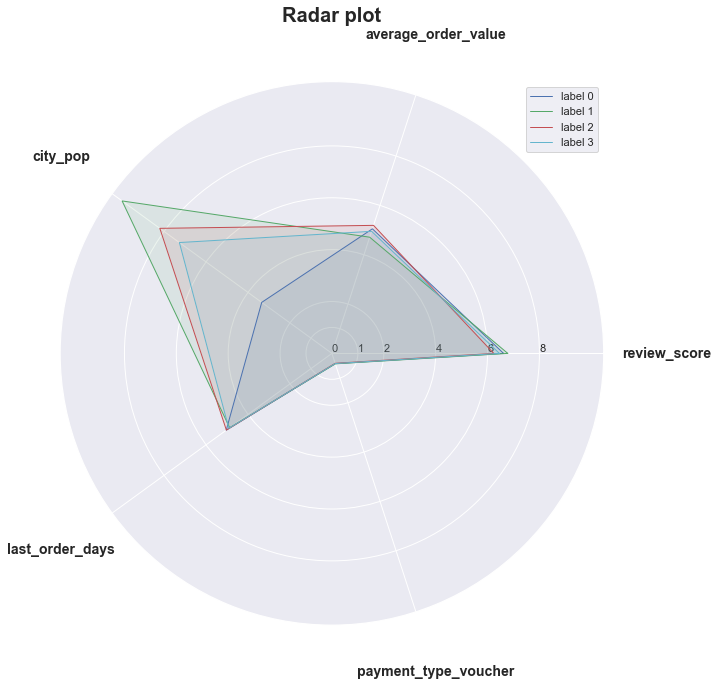

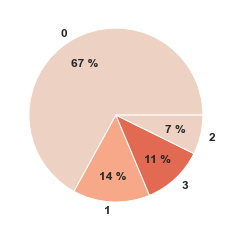

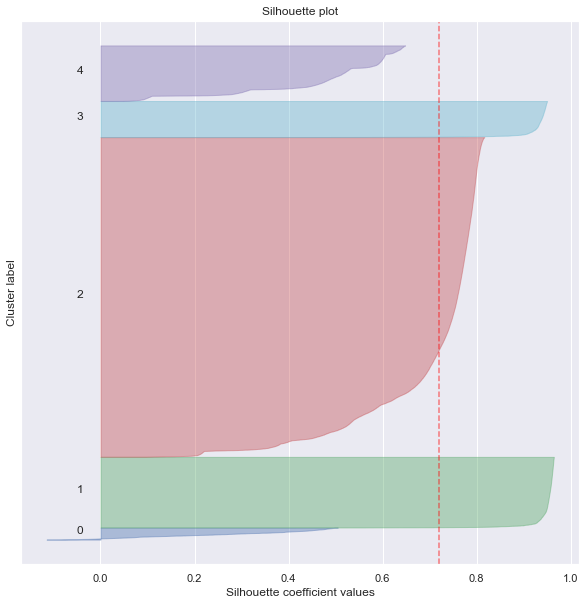

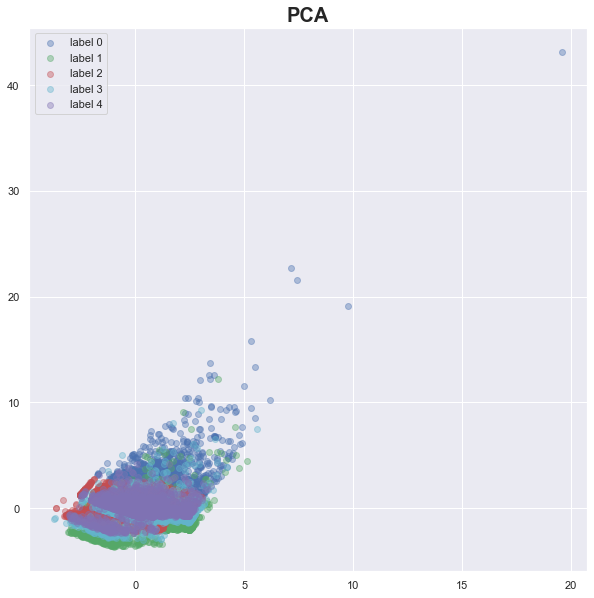

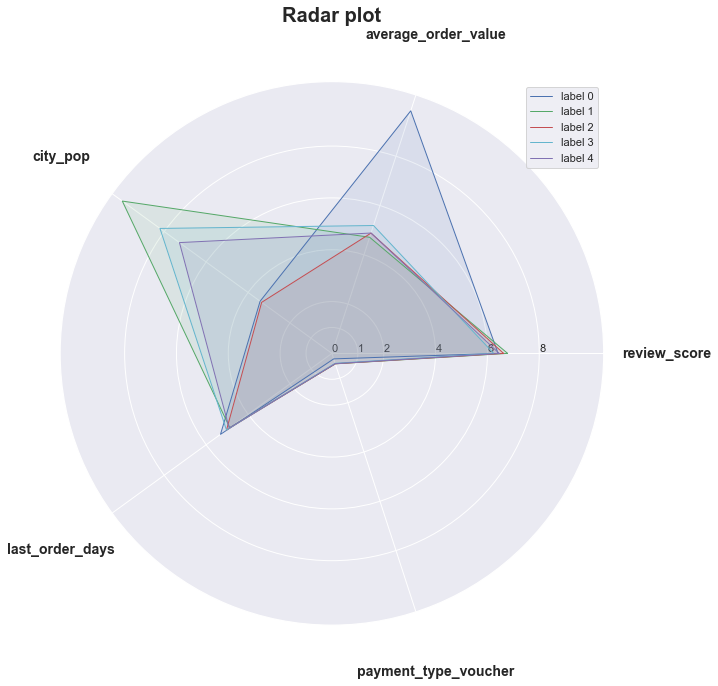

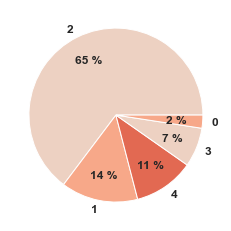

In [14]:
for n_clusters in np.arange(3, 6):
    kmeans, cluster_labels = train_kmeans(data, n_clusters)
    silhouette_avg = ssa[n_clusters - 2]
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    draw_silhouette_plot(data, n_clusters, cluster_labels, silhouette_avg)
    draw_pca_plot(data)
    draw_radar_plot(data, n_clusters, cluster_labels, features)
    draw_cluster_distribution(cluster_labels)

### Custom variables 2

100%|█████████████████████████████████████████████| 5/5 [06:36<00:00, 79.30s/it]


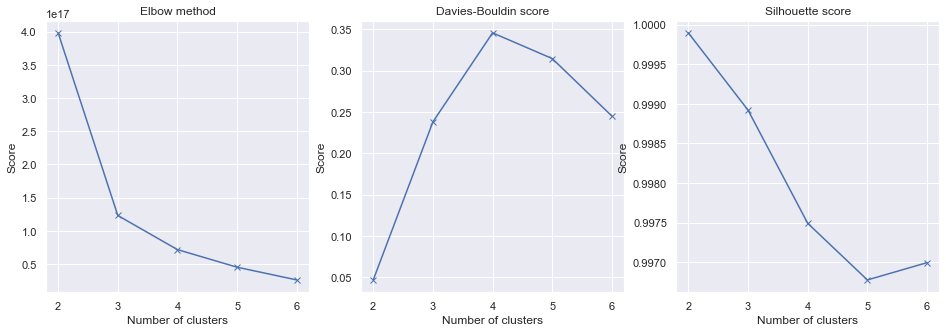

In [15]:
features = [
    "review_score",
    "average_order_value",
    "order_weight",
    "order_volume",
    "city_pop"
]

data = customer_data[features]
max_clusters = 6
sse, dbs, ssa = plot_scores(data, max_clusters)

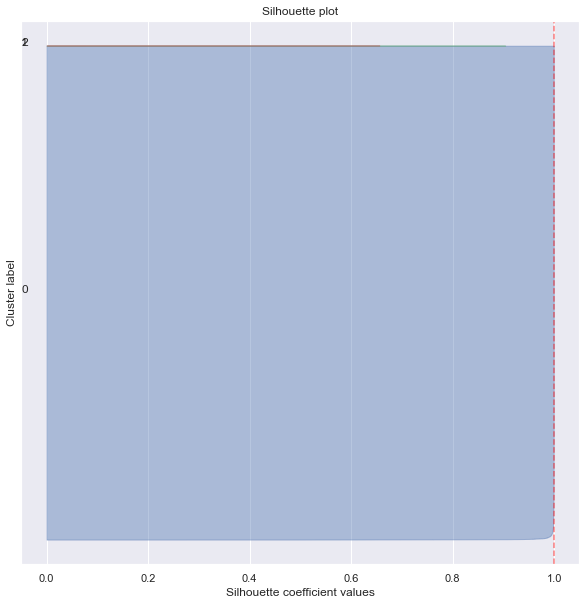

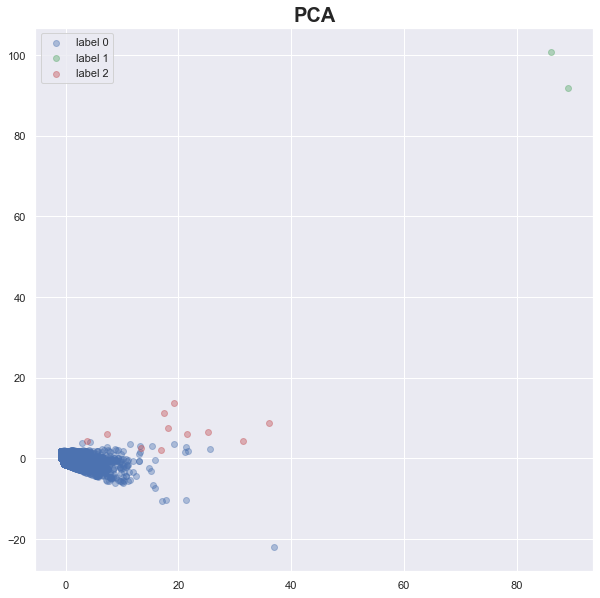

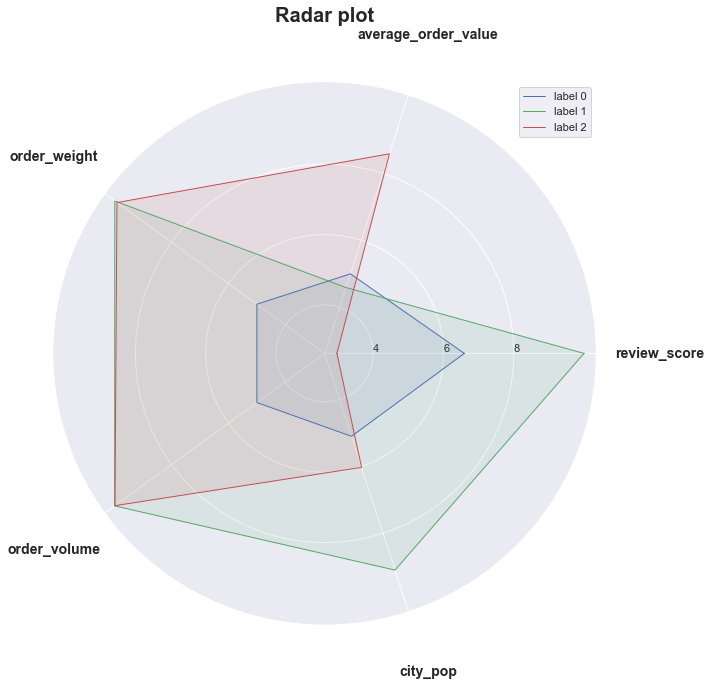

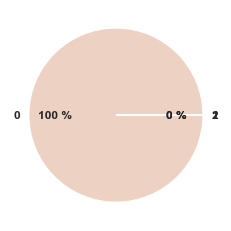

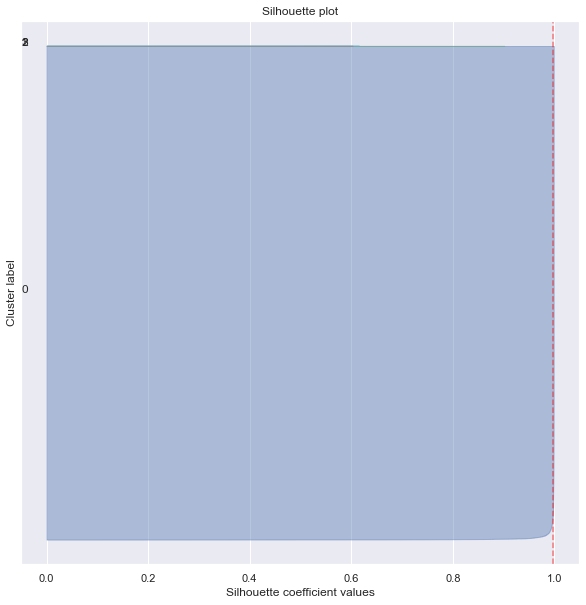

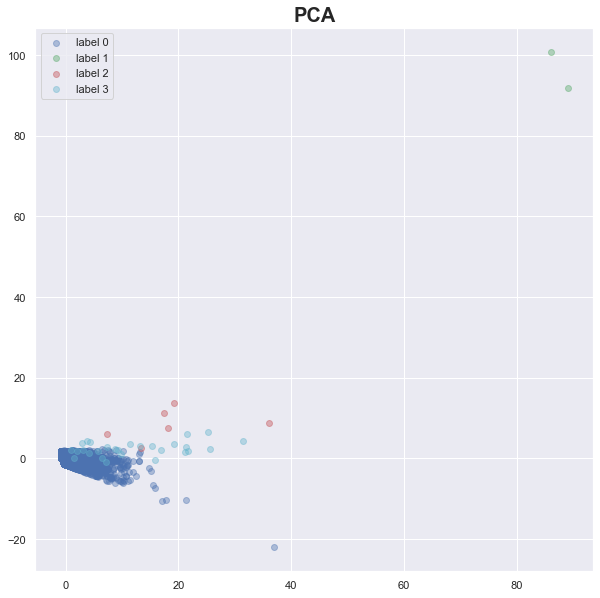

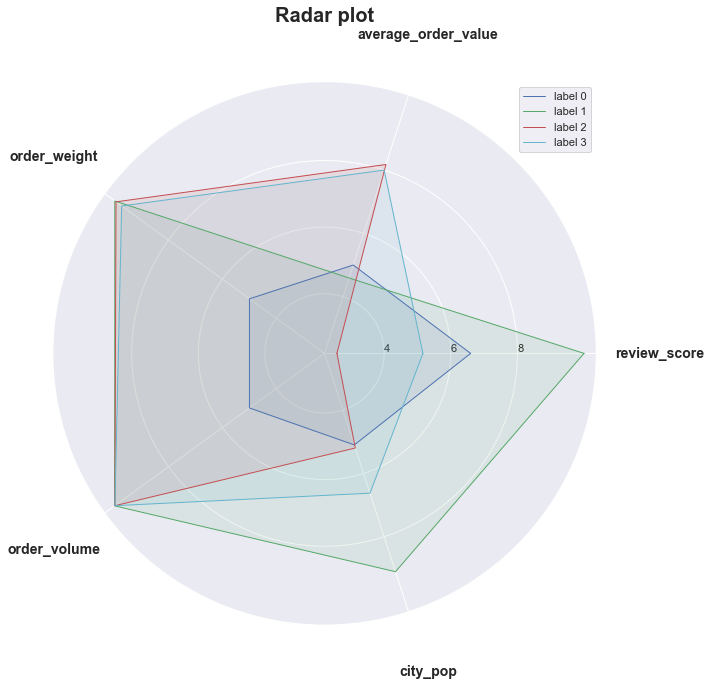

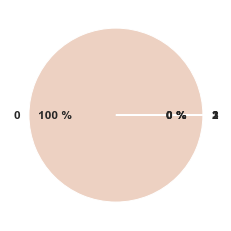

In [16]:
for n_clusters in np.arange(3, 5):
    kmeans, cluster_labels = train_kmeans(data, n_clusters)
    silhouette_avg = ssa[n_clusters - 2]
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    draw_silhouette_plot(data, n_clusters, cluster_labels, silhouette_avg)
    draw_pca_plot(data)
    draw_radar_plot(data, n_clusters, cluster_labels, features)
    draw_cluster_distribution(cluster_labels)

### Custom variables 3

100%|█████████████████████████████████████████████| 5/5 [04:43<00:00, 56.64s/it]


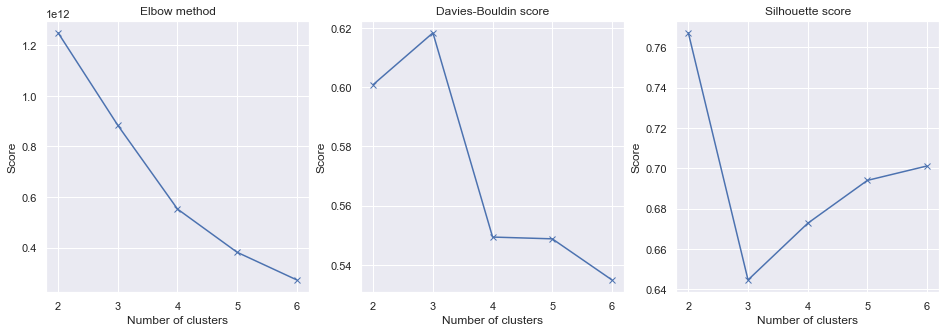

In [17]:
features = [
    "review_score",
    "average_order_value",
    "order_weight",
    "payment_installments",
    "city_pop",
]

data = customer_data[features]
max_clusters = 6
sse, dbs, ssa = plot_scores(data, max_clusters)

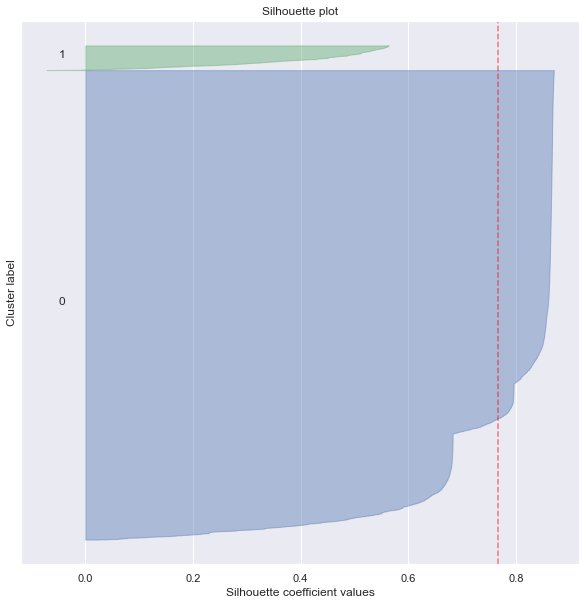

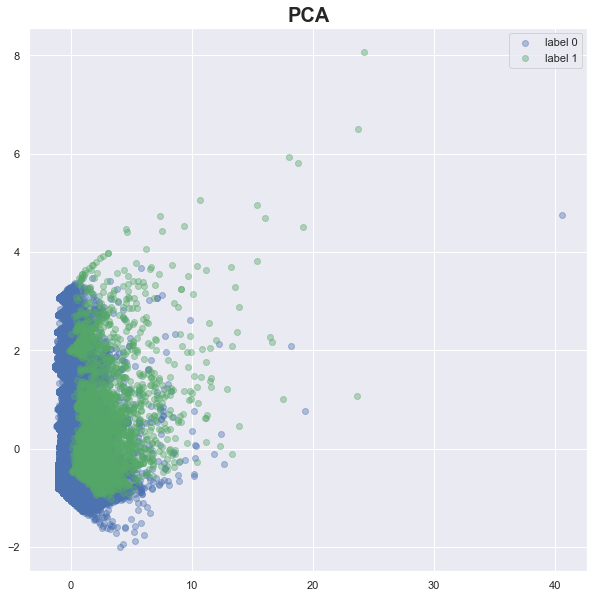

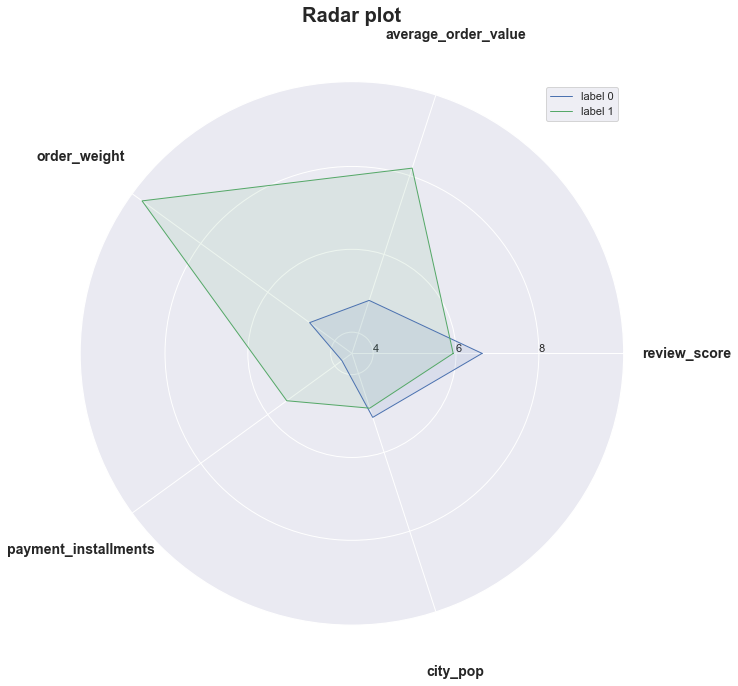

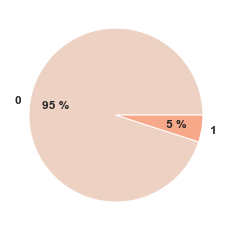

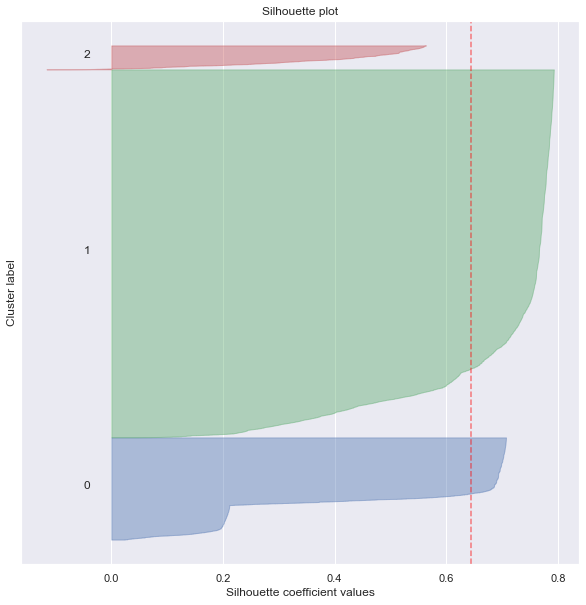

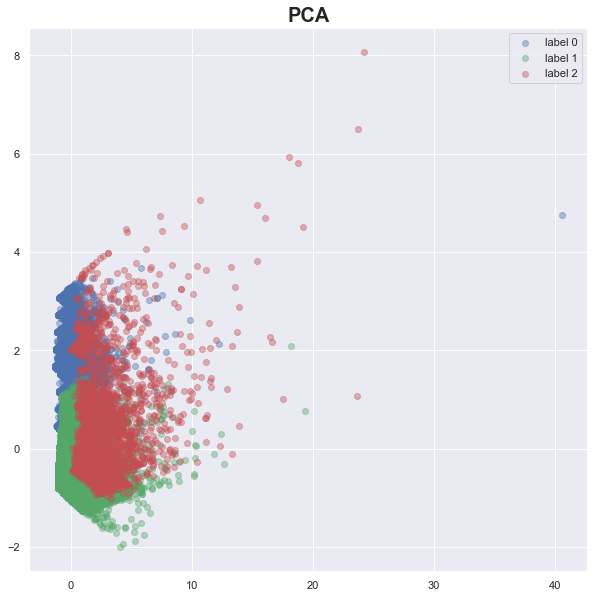

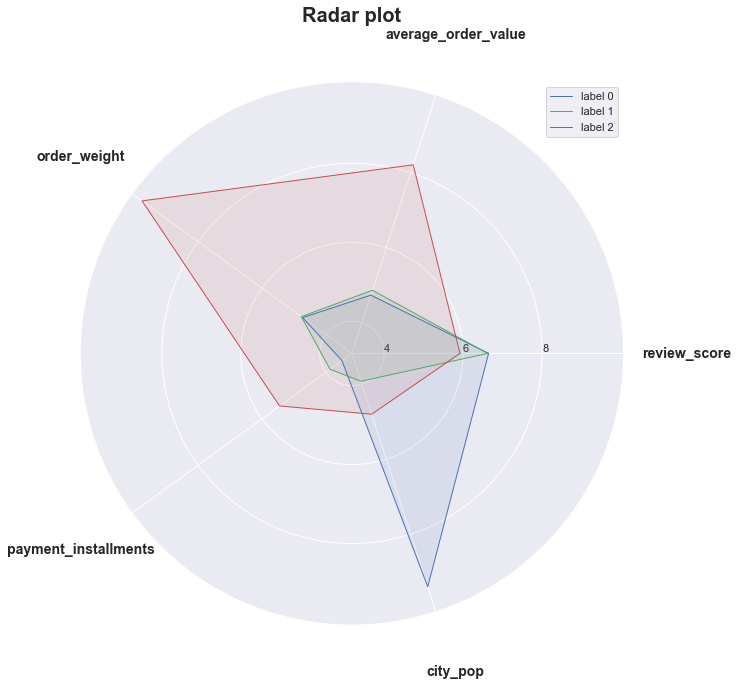

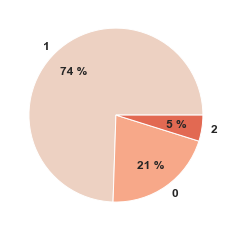

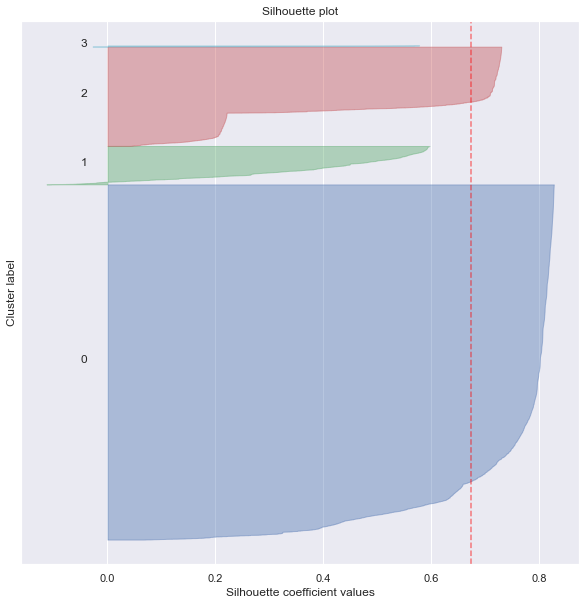

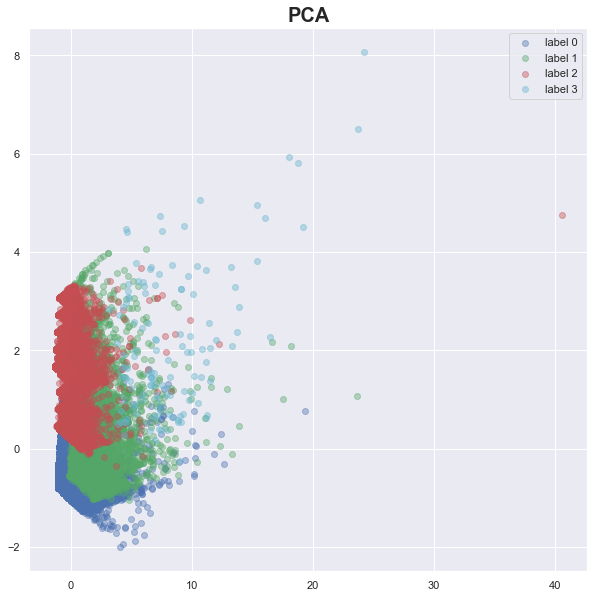

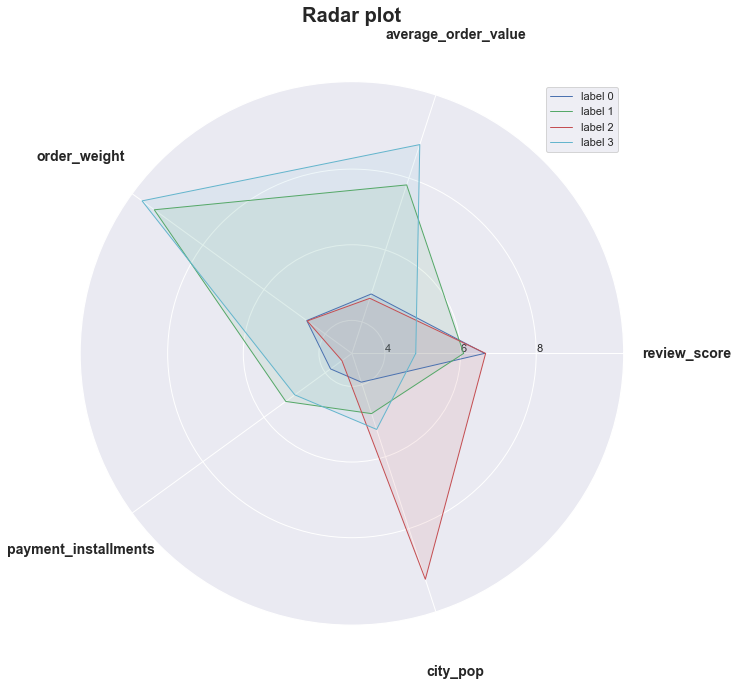

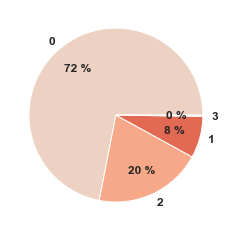

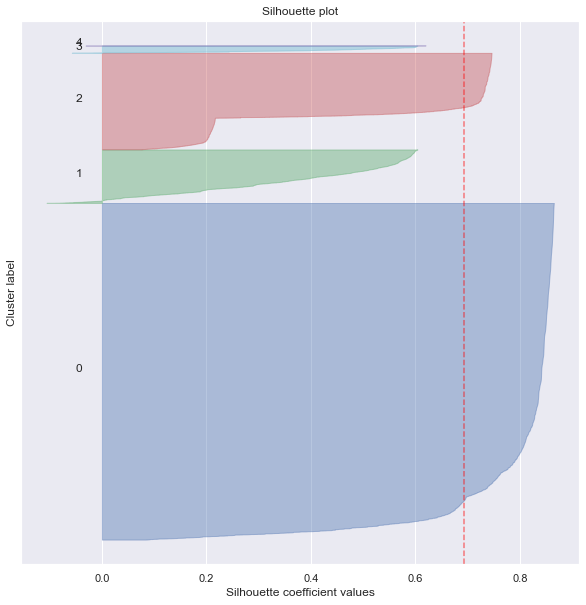

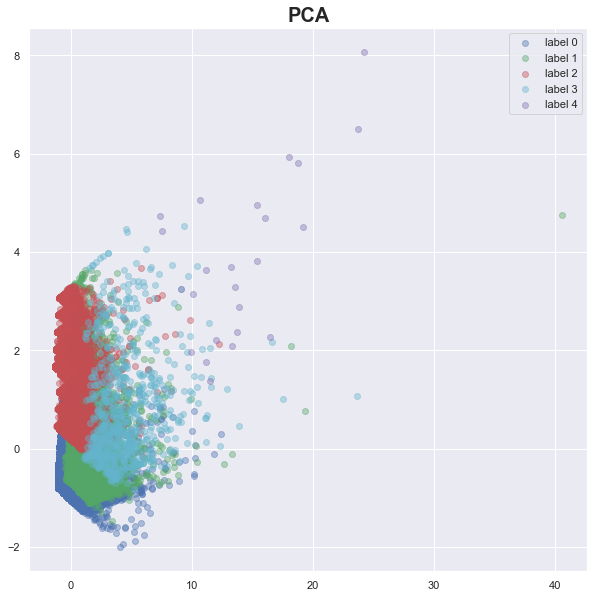

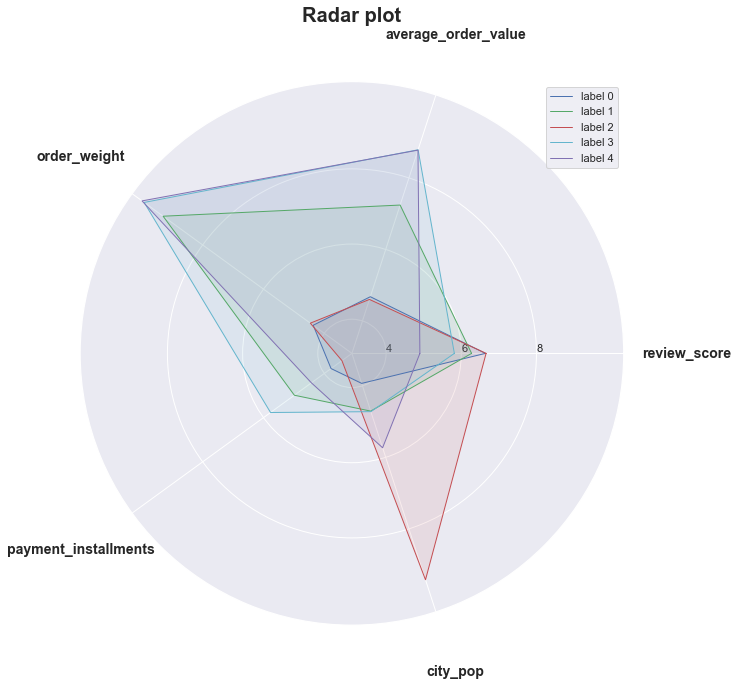

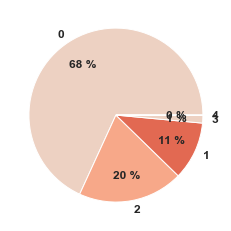

In [18]:
for n_clusters in np.arange(2, 6):
    kmeans, cluster_labels = train_kmeans(data, n_clusters)
    silhouette_avg = ssa[n_clusters - 2]
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    draw_silhouette_plot(data, n_clusters, cluster_labels, silhouette_avg)
    draw_pca_plot(data)
    draw_radar_plot(data, n_clusters, cluster_labels, features)
    draw_cluster_distribution(cluster_labels)

### DBSCAN

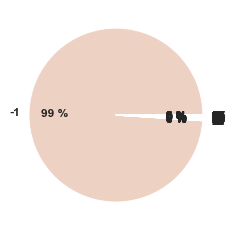

In [29]:
dbscan, cluster_labels = train_dbscan(data, eps=0.5, min_samples=5)
draw_cluster_distribution(cluster_labels)

### Modèle sélectionné

100%|█████████████████████████████████████████████| 5/5 [04:40<00:00, 56.05s/it]


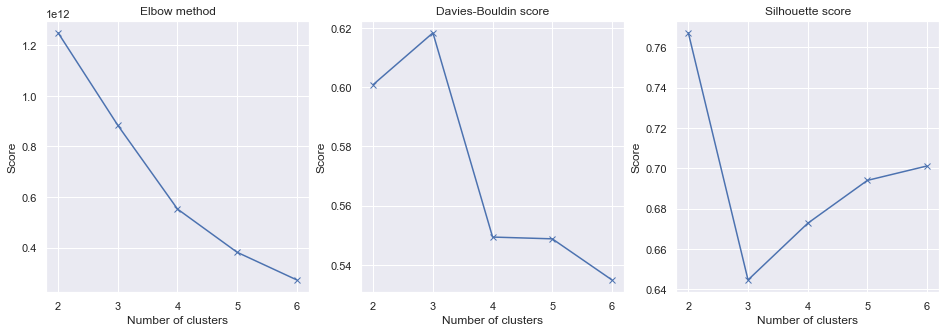

In [20]:
features = [
    "review_score",
    "average_order_value",
    "order_weight",
    "payment_installments",
    "city_pop",
]

data = customer_data[features]
max_clusters = 6
sse, dbs, ssa = plot_scores(data, max_clusters)

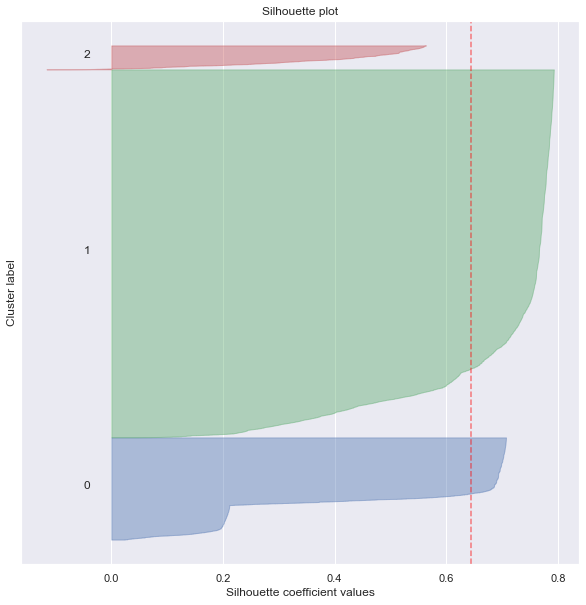

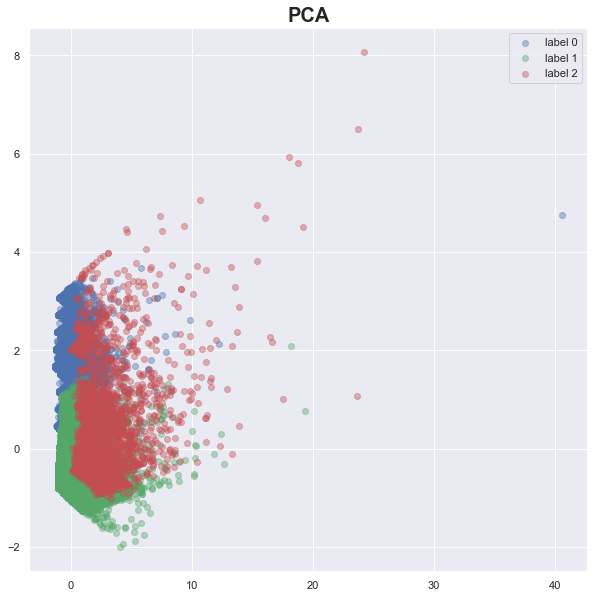

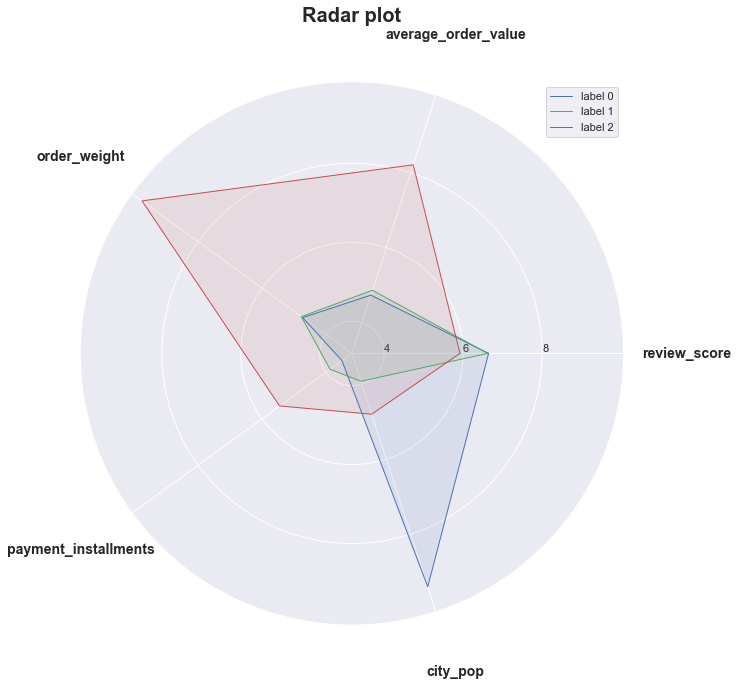

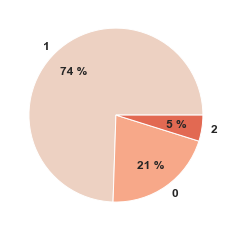

In [21]:
n_clusters = 3
kmeans, cluster_labels = train_kmeans(data, n_clusters)
silhouette_avg = ssa[n_clusters - 2]
sample_silhouette_values = silhouette_samples(data, cluster_labels)
draw_silhouette_plot(data, n_clusters, cluster_labels, silhouette_avg)
draw_pca_plot(data)
draw_radar_plot(data, n_clusters, cluster_labels, features)
draw_cluster_distribution(cluster_labels)

## Contrat de monitoring

### Evolution du silhouette score

In [22]:
label_sizes, ssa_list = list(), list()
n_clusters = 3

for n_month in sorted(np.arange(0, 8, 2), reverse=True):
    customer_data = get_customer_data(order_data, n_month)
    data = customer_data[features]
    kmeans, cluster_labels = train_kmeans(data, n_clusters, seed)
    label_sizes.append(np.bincount(cluster_labels))
    ssa_list.append(silhouette_score(data, cluster_labels))

Number of orders removed: 39324
Number of orders removed: 25699
Number of orders removed: 12714
Number of orders removed: 0


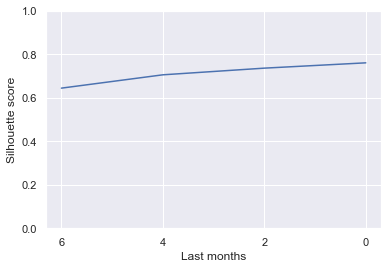

In [23]:
plt.figure()
sns.lineplot(x=np.arange(0,4), y = ssa_list)
plt.xticks([0, 1, 2, 3], labels=["6", "4", "2", "0"])
plt.xlabel('Last months')
plt.ylabel('Silhouette score')
plt.gca().set_ylim([0,1])
plt.show()

### Evolution de la répartition des segments (avec nouveaux clients)

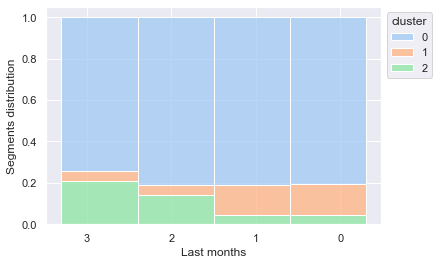

In [24]:
monitoring_data = pd.DataFrame(label_sizes)
monitoring_data = monitoring_data.div(monitoring_data.sum(axis=1), axis = 0)
monitoring_data = monitoring_data.rename_axis('month').reset_index().melt('month').rename(columns={'variable':'cluster'})

ax = sns.histplot(monitoring_data, x='month', hue='cluster', weights='value', multiple='stack', palette='pastel', shrink=3)
ax.set_ylabel('percentage')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
plt.xticks([0, 1, 2, 3], labels=["3", "2", "1", "0"])
plt.xlabel('Last months')
plt.ylabel('Segments distribution')
plt.show()

### Evolution du score ARI (même clients)

In [25]:
ari_list = [1]
customer_data = get_customer_data(order_data, 6)
customer_list = customer_data.index.unique()
data = customer_data[features]
kmeans, true_labels = train_kmeans(data, n_clusters, seed)

for n_month in sorted(np.arange(0, 6, 2), reverse=True):
    customer_data = get_customer_data(order_data.loc[order_data.customer_id.isin(customer_list)], n_month)
    data = customer_data[features]
    kmeans, cluster_labels = train_kmeans(data, n_clusters, seed)
    ari_list.append(adjusted_rand_score(true_labels, cluster_labels))

Number of orders removed: 39324
Number of orders removed: 430
Number of orders removed: 185
Number of orders removed: 0


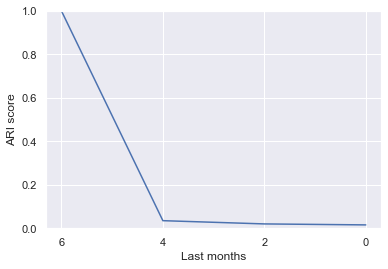

In [26]:
plt.figure()
sns.lineplot(x=np.arange(0,4), y = ari_list)
plt.xticks([0, 1, 2, 3], labels=["6", "4", "2", "0"])
plt.xlabel('Last months')
plt.ylabel('ARI score')
plt.gca().set_ylim([0,1])
plt.show()